# Wavelet transform

In [1]:
import os
import numpy as np
import pywt
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline

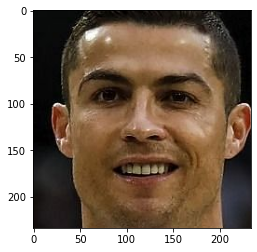

In [2]:
img = cv2.imread("./test_images/cristiano_ronaldo0.png")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pixels = np.array(image)

plt.imshow(pixels)
plt.show()

In [3]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

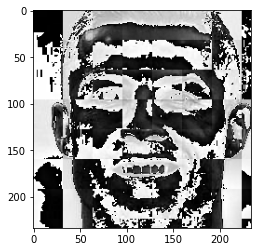

In [4]:
im_har = w2d(img,'db1',5)
plt.imshow(im_har, cmap='gray')

# Model building

In [5]:
path_to_cr_data = "./cropped_images/"

In [6]:
cropped_image_dirs = os.listdir(path_to_cr_data)
cropped_image_dirs

['conor_mcgregor',
 'cristiano_ronaldo',
 'kane williamson',
 'khabib',
 'lionel_messi',
 'virat_kohli']

In [7]:
celebrity_file_names_dict = {}

for img_dir in cropped_image_dirs:
    celebrity_name = str(img_dir)
    file_list = []
    for entry in os.scandir(path_to_cr_data+celebrity_name):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [8]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'conor_mcgregor': 0,
 'cristiano_ronaldo': 1,
 'kane williamson': 2,
 'khabib': 3,
 'lionel_messi': 4,
 'virat_kohli': 5}

In [9]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        
        # stacking coloured image and wavelet transformed image
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [10]:
X[0]

array([[ 35],
       [ 28],
       [ 25],
       ...,
       [244],
       [249],
       [246]], dtype=uint8)

In [11]:
len(X[0])

4096

In [12]:
X = np.array(X).reshape(len(X),4096).astype(float)
y = np.array(y).reshape(-1, 1)
X.shape, y.shape

((239, 4096), (239, 1))

In [14]:
X[0]

array([ 35.,  28.,  25., ..., 244., 249., 246.])

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6666666666666666

In [17]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.22      1.00      0.36         2
           2       1.00      0.40      0.57         5
           3       1.00      0.67      0.80         3
           4       1.00      0.67      0.80         3
           5       1.00      0.80      0.89         5

    accuracy                           0.67        24
   macro avg       0.84      0.70      0.69        24
weighted avg       0.89      0.67      0.72        24



# Trying different models with Gridsearch

In [18]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [19]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [20]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

,model,best_score,best_params
0,svm,0.762791,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.548837,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.804651,{'logisticregression__C': 5}


In [21]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [22]:
best_estimators['svm'].score(X_test,y_test)

0.7083333333333334

In [23]:
best_estimators['random_forest'].score(X_test,y_test)

0.5416666666666666

In [24]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.875

In [25]:
best_clf = best_estimators['logistic_regression']

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 0, 0, 0, 1, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 1, 0, 0, 2, 0],
       [0, 0, 1, 0, 0, 4]], dtype=int64)

Text(69.0, 0.5, 'Truth')

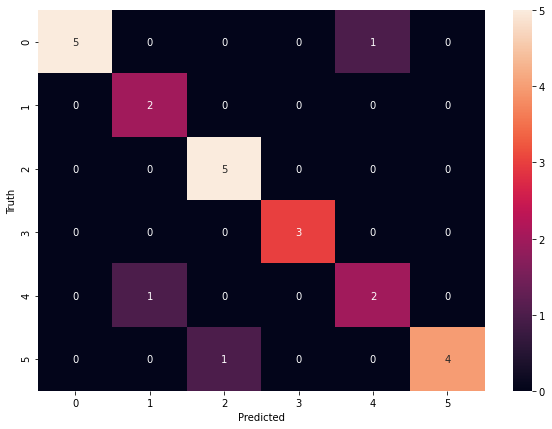

In [27]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
class_dict

{'conor_mcgregor': 0,
 'cristiano_ronaldo': 1,
 'kane williamson': 2,
 'khabib': 3,
 'lionel_messi': 4,
 'virat_kohli': 5}

# Saving the Logistic Regression model

In [29]:
import pickle
pickle.dump(best_clf, open('lr_model.pkl', 'wb'))

# Saving class dict 

In [30]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

# CNN Model

In [31]:
batch_size = 16
img_height = 32
img_width = 32

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [76]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_cr_data,
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 239 files belonging to 6 classes.
Using 216 files for training.


In [78]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_cr_data,
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 239 files belonging to 6 classes.
Using 23 files for validation.


In [80]:
class_names = class_dict.keys()
print(class_names, len(class_names))

dict_keys(['conor_mcgregor', 'cristiano_ronaldo', 'kane williamson', 'khabib', 'lionel_messi', 'virat_kohli']) 6


In [98]:
# creating the model
num_classes = len(class_names)

model = Sequential([    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)
])

In [99]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 64)        

In [100]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
14/14 [==============================] - 1s 61ms/step - loss: 1.7601 - accuracy: 0.2778 - val_loss: 1.8614 - val_accuracy: 0.1739
Epoch 2/15
14/14 [==============================] - 1s 49ms/step - loss: 1.6611 - accuracy: 0.3843 - val_loss: 1.8273 - val_accuracy: 0.3043
Epoch 3/15
14/14 [==============================] - 1s 45ms/step - loss: 1.5502 - accuracy: 0.4306 - val_loss: 1.5955 - val_accuracy: 0.3913
Epoch 4/15
14/14 [==============================] - 1s 46ms/step - loss: 1.2564 - accuracy: 0.5556 - val_loss: 1.4925 - val_accuracy: 0.4783
Epoch 5/15
14/14 [==============================] - 1s 45ms/step - loss: 0.9659 - accuracy: 0.6389 - val_loss: 1.1092 - val_accuracy: 0.6087
Epoch 6/15
14/14 [==============================] - 1s 48ms/step - loss: 0.7135 - accuracy: 0.7407 - val_loss: 0.8724 - val_accuracy: 0.6087
Epoch 7/15
14/14 [==============================] - 1s 46ms/step - loss: 0.5196 - accuracy: 0.8333 - val_loss: 0.7494 - val_accuracy: 0.7826
Epoch 8/15
14

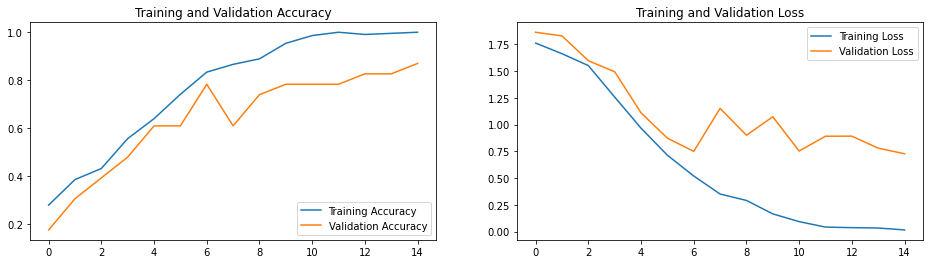

In [120]:
# Visualize training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [119]:
model.evaluate(val_ds)

2/2 [==============================] - 0s 3ms/step - loss: 0.7270 - accuracy: 0.8696


[0.7269999384880066, 0.8695651888847351]

In [122]:
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model\assets
